In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

In [14]:
base_path = "data" 
output_csv = "processed_data.csv"

data_records = []

for param in ["PR", "GHI"]:
    param_path = os.path.join(base_path, param)

    for year_month in sorted(os.listdir(param_path)):
        ym_path = os.path.join(param_path, year_month)
      
        for file in sorted(os.listdir(ym_path)):
            if file.endswith(".csv"):
                file_path = os.path.join(ym_path, file)
                date_str = file.replace("_PR.csv", "").replace("_GHI.csv", "").replace(".csv", "")
                

                df = pd.read_csv(file_path)
                numeric_cols = df.select_dtypes(include=["number"]).columns
                if len(numeric_cols) > 0:
                    value = df[numeric_cols[0]].iloc[0]
                else:
                    value = df.iloc[0, 1]

                data_records.append({
                    "Date": pd.to_datetime(date_str, format="%Y-%m-%d"),
                    "Parameter": param,
                    "Value": float(value)
                })


df_all = pd.DataFrame(data_records)

df_pivot = df_all.pivot(index="Date", columns="Parameter", values="Value").reset_index()
df_pivot.to_csv(output_csv, index=False)

print(f"Processed data saved to '{output_csv}' with {len(df_pivot)} rows.")


Processed data saved to 'processed_data.csv' with 197 rows.


In [15]:
df_pivot

Parameter,Date,GHI,PR
0,2019-07-01,3.256608,69.575676
1,2019-07-06,5.179733,82.764172
2,2019-07-11,6.261125,70.938886
3,2019-07-16,3.324450,74.833220
4,2019-07-21,4.940125,65.365044
...,...,...,...
192,2022-03-03,6.092025,66.981888
193,2022-03-08,6.368117,62.233068
194,2022-03-13,5.754642,81.834824
195,2022-03-18,4.700167,67.242108


In [16]:
def plot_pr_graph(df, start_date=None, end_date=None):
    if start_date:
        df = df[df["Date"] >= pd.to_datetime(start_date)]
    if end_date:
        df = df[df["Date"] <= pd.to_datetime(end_date)]

    df = df.sort_values("Date").reset_index(drop=True)

    # 30-day moving average
    df["PR_MA30"] = df["PR"].rolling(30).mean()

    # Budget PR line 
    start_value = 73.9
    start_date_budget = df["Date"].min()
    budget_values = []
    for d in df["Date"]:
        years_passed = (d.year - start_date_budget.year) + ((d.month - start_date_budget.month) / 12)
        budget_pr = start_value * ((1 - 0.008) ** years_passed)
        budget_values.append(budget_pr)
    df["Budget_PR"] = budget_values

    # Color coding
    def get_color(ghi):
        if ghi < 2: return "navy"
        elif ghi < 4: return "lightblue"
        elif ghi < 6: return "orange"
        else: return "brown"

    colors = df["GHI"].apply(get_color)


    fig, ax = plt.subplots(figsize=(14, 7))
    ax.scatter(df["Date"], df["PR"], c=colors, s=15, alpha=0.7, label="Daily PR")
    ax.plot(df["Date"], df["PR_MA30"], color="red", linewidth=2, label="30-d moving avg of PR")
    ax.plot(df["Date"], df["Budget_PR"], color="green", linewidth=2, label="Target Budget Yield Performance Ratio")
    pct_above = (df["PR"] > df["Budget_PR"]).mean() * 100
    ax.text(0.02, 0.92, f"Points above Target Budget PR = {pct_above:.1f}%", 
            transform=ax.transAxes, fontsize=11, bbox=dict(facecolor="white", alpha=0.6))
    ax.set_title(f"Performance Ratio Evolution\nFrom {df['Date'].min().date()} to {df['Date'].max().date()}",
                 fontsize=14)

    ax.set_ylabel("Performance Ratio (PR) [%]")
    ax.set_xlabel("Date")

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))
    plt.xticks(rotation=0)

    ax.legend(loc="upper right")

    stats = {
        "last 7d": df["PR"].tail(7).mean(),
        "last 30d": df["PR"].tail(30).mean(),
        "last 60d": df["PR"].tail(60).mean(),
        "last 180d": df["PR"].tail(180).mean(),
        "last 365d": df["PR"].tail(365).mean(),
        "lifetime": df["PR"].mean()
    }

    textstr = "\n".join([f"Average PR {k}: {v:.1f} %" for k, v in stats.items()])
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    ax.text(0.98, 0.02, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment="bottom", horizontalalignment="right", bbox=props)

    plt.tight_layout()
    plt.show()

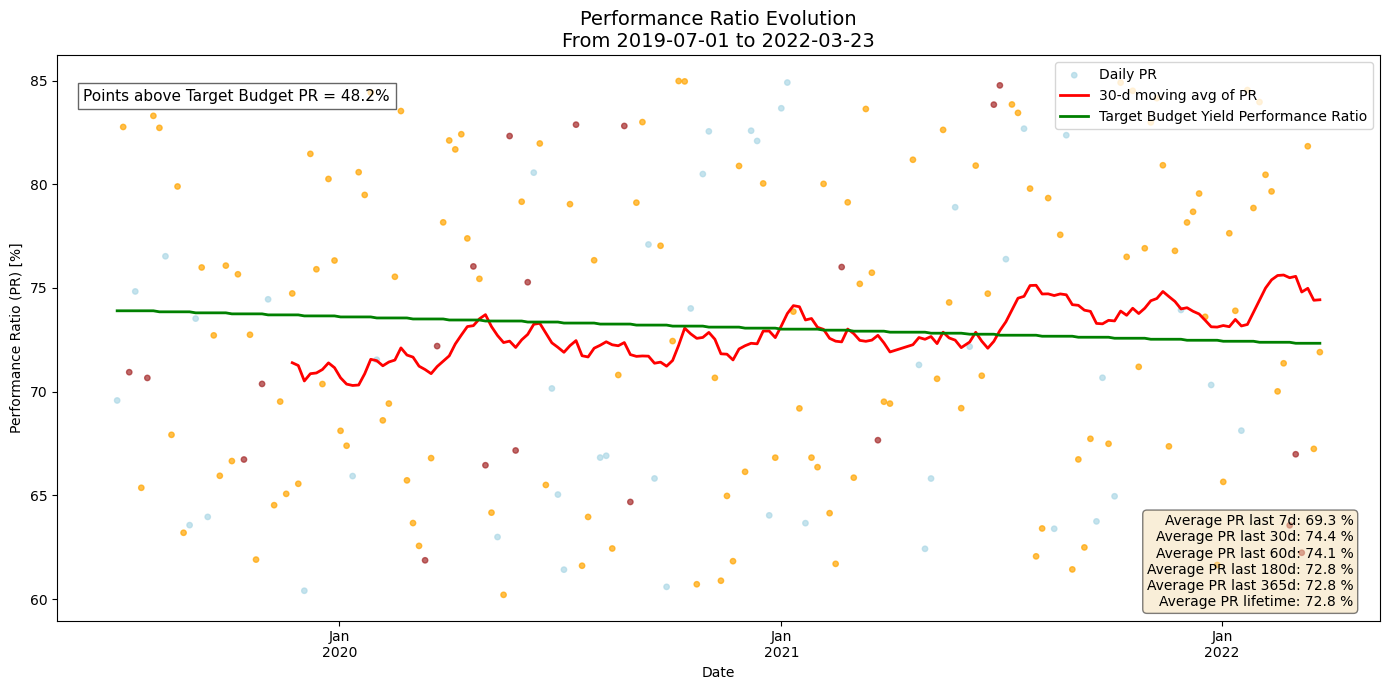

In [21]:
plot_pr_graph(df_pivot, start_date="2019-07-01", end_date="2022-03-24")